<h1>Parts of Speech</h1>

This step contains analysis of parts of speech (POS) frequency in the Beatles songs.

In [1]:
%matplotlib inline
import operator
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import HTML, display
from collections import Counter

For POS identification I decided to try <a href="https://spacy.io/">SpaCy</a>. Still, one must keep in mind that all the figures below are not accurate for 100%, as accuracy of tagging algorithms is not perfect.

In [2]:
import spacy
nlp = spacy.load('en')

In [3]:
df = pd.read_json('data.json')

In [4]:
def count_frequencies(cleaned_lyrics):
    '''
        Count relative frequency for each word in lyrics
    '''    
    
    split_cleaned_lyrics = cleaned_lyrics.str.split()
    lyrics = [w for song in list(split_cleaned_lyrics.values) for w in song]
    lyrics_count = len(lyrics)
    unique_words_count = len(set(lyrics))
    c = Counter(lyrics)
    raw_figures = sorted(c.items(), key=operator.itemgetter(1), reverse=True)
    shares = [(rf[0], round(float(100*rf[1])/lyrics_count, 2)) for rf in raw_figures]
    return shares, unique_words_count, lyrics_count

In [5]:
def get_pos(song, tags=True):
    '''
        Get a POS tag for every word in a song
    '''
    
    def get_sentences(song):
        song_string = song.replace('[', '').replace(']', '')
        song_string = song.replace('&#13;', '')
        song_string = song_string.replace('<p>', '<br/>')
        song_string = song_string.replace('</p>', '')
        return [s.strip(' ') for s in song_string.split('<br/>') if s]
    
    output = []
    
    for sentence in get_sentences(song):
    
        song_obj = nlp(sentence)
        
        if tags:
            output.extend([token.tag_ for token in song_obj])
        else:
            output.extend([token.pos_ for token in song_obj])
    
    output = ' '.join(output) 
    return output

In [6]:
df['cleaned_lyrics_pos_tags'] = df['lyrics'].apply(get_pos)
df['cleaned_lyrics_pos'] = df['lyrics'].apply(get_pos, tags=False)

With all preparations done, let's analyze POS frequency in the Beatles songs.

In [7]:
shares, unique_pos_number, total_pos_number = count_frequencies(df['cleaned_lyrics_pos'])

In [8]:
print ("Unique POS number: %i" % unique_pos_number)

print ("POS frequency, %:")

for pos, freq in shares:
    print (pos, freq)

Unique POS number: 15
POS frequency, %:
VERB 24.7
PRON 15.55
NOUN 13.15
ADV 8.23
PUNCT 7.55
ADJ 6.76
ADP 6.3
DET 5.87
INTJ 3.46
PART 2.86
PROPN 2.57
CCONJ 2.2
NUM 0.54
X 0.27
SYM 0.0


So we have 15 unique POS categories. Let's plot the frequencies!

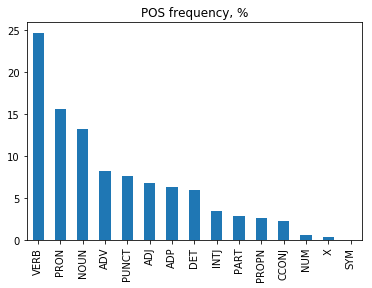

In [9]:
df_freq = pd.Series([s[1] for s in shares], index=[s[0] for s in shares])
df_freq.plot.bar(title='POS frequency, %')

So verbs have the first place, then we see pronouns and nouns not that far from each other. Adverbs, adjectives and others are less common (see full label descriptions <a href="https://spacy.io/api/annotation">here</a>).

One can now ask how well these results correspond to POS frequency in other texts in English.

The <a href="http://www.aclweb.org/anthology/O00-1009">work of Rebecca H. Shih, John Y. Chiang, and F. Tien</a> (2000) gives the following distribution for the British National Corpus:

Noun: 24%<br>
Verb: 15%<br>
Punctuation: 12%<br>
Preposition: 11%<br>
Adjective: 8%<br>
Pronoun: 8%<br>
Article: 8%<br>
Adverb: 5%<br>

Some interesting information was <a href="http://infomotions.com/blog/2011/02/forays-into-parts-of-speech/">presented</a> by Eric Lease Morgan (2011): 

Noun: 19%<br>
Verb: 15%<br>
Punctuation: 14%<br>
Preposition: 13%<br>
Determiner: 10%<br>
Pronoun: 9%<br>
Adverb: 7%<br>
Adjective: 6%<br>
Conjunction: 4%<br>

We see that while figures can be different, the top four is the same in both cases: Noun - Verb - Punctuation - Preposition.

In the Beatles lyrics it's completely different: Verb - Pronoun - Noun - Adverb.

Now let's see how these figues were changing with time.

In [10]:
def show_table(shares, limit, headlines):
    '''
        Display an html table with shares data
    '''    
    
    words_by_column = '<tr>'
    
    for headline in headlines:
        words_by_column = words_by_column + '<td></td><td><strong>%s</strong></td>' % str(headline)
    words_by_column = words_by_column + '</tr>'    
    
    if limit == 0:
        limit = len(shares[0])
    
    for i in range(0, limit):

        words_by_column = words_by_column + '<tr>'

        for st in shares:
            
            if i < len(st):
                words_by_column = words_by_column + '<td>{}</td><td>{:.2f}</td>'.format(st[i][0], st[i][1])
            else:
                words_by_column = words_by_column + '<td>-</td><td>-</td>'

        words_by_column = words_by_column + '</tr>'    
        
    display(HTML('<table>' + words_by_column + '</table>'))

In [11]:
shares_total = []

for year in range(1963, 1971):
    shares_year, uniq_pos_number, pos_total = count_frequencies(df[df['year']==year]['cleaned_lyrics_pos'])
    shares_total.append(shares_year)
shares_total.append(shares)

show_table(shares_total, 10, list(range(1963, 1971)) + ['Total'])

,1963,,1964,,1965,,1966,,1967,,1968,,1969,,1970,,Total
VERB,24.57,VERB,27.86,VERB,27.28,VERB,24.50,VERB,23.34,VERB,22.65,VERB,21.23,VERB,24.44,VERB,24.70
PRON,18.32,PRON,18.76,PRON,17.79,NOUN,15.84,NOUN,15.86,NOUN,13.90,PRON,13.89,PRON,16.95,PRON,15.55
NOUN,10.87,NOUN,13.01,NOUN,12.12,PRON,14.55,PRON,11.53,PRON,11.80,NOUN,12.27,NOUN,12.60,NOUN,13.15
PUNCT,9.56,ADV,8.79,ADV,9.39,PUNCT,8.66,ADJ,7.86,PUNCT,7.68,ADV,11.89,PUNCT,8.09,ADV,8.23
ADV,8.49,ADP,6.34,ADJ,6.78,ADJ,7.57,PUNCT,7.77,ADJ,6.62,PUNCT,9.36,ADP,6.98,PUNCT,7.55
ADP,6.28,ADJ,6.10,ADP,6.14,DET,7.08,DET,7.64,INTJ,6.56,ADJ,7.85,ADV,6.66,ADJ,6.76
ADJ,5.92,DET,4.98,PUNCT,6.10,ADV,6.82,ADV,6.54,ADV,6.51,DET,6.19,DET,6.18,ADP,6.30
DET,4.63,PUNCT,4.79,DET,5.29,ADP,6.22,ADP,6.51,ADP,6.39,ADP,5.74,ADJ,5.54,DET,5.87
INTJ,4.34,PART,3.15,PART,3.00,PART,2.54,PROPN,4.04,DET,6.20,PART,3.14,INTJ,4.63,INTJ,3.46
CCONJ,2.22,CCONJ,2.66,CCONJ,2.82,CCONJ,2.30,PART,3.18,PROPN,6.04,INTJ,2.89,PROPN,3.23,PART,2.86


We see that verbs are always leaders. Pronouns and nouns fight for the second place, with nouns winning in 1965, 1966 and 1967. 

It's time to look at the authors.

In [12]:
shares_total = []
for writer in ('Lennon', 'McCartney', 'Harrison'):
    shares_by_writer, uniq_pos_number, pos_total = count_frequencies(df[df['writers']==writer]['cleaned_lyrics_pos'])
    shares_total.append(shares_by_writer)

show_table(shares_total, 10, ['Lennon', 'McCartney', 'Harrison'])

,Lennon,,McCartney,,Harrison
VERB,26.58,VERB,23.46,VERB,24.67
PRON,16.19,PRON,14.01,PRON,18.96
NOUN,13.06,NOUN,12.78,ADV,11.99
PUNCT,7.58,ADV,8.85,NOUN,10.22
ADV,6.92,PUNCT,7.52,ADJ,8.15
ADJ,6.43,ADP,6.48,ADP,6.39
ADP,5.89,DET,5.88,PUNCT,6.08
DET,5.75,ADJ,5.69,DET,5.91
PART,3.51,INTJ,5.15,PART,2.35
INTJ,3.36,PROPN,3.95,CCONJ,2.32


We see that all the three place verbs and pronouns on the first and the second place respectively. But as for on the third place, Harrison favours adverbs while the two others prefer nouns.

What about cover songs then?

In [13]:
df_cover = df[df.cover==True]
df_orig = df[df.cover==False]

shares_orig, uniq_pos_number, pos_total = count_frequencies(df_orig['cleaned_lyrics_pos'])
shares_cover, uniq_pos_number, pos_total  = count_frequencies(df_cover['cleaned_lyrics_pos'])

shares_total = [shares_orig, shares_cover, shares]
show_table(shares_total, 10, ['Original', 'Cover', 'Total'])

,Original,,Cover,,Total
VERB,24.86,VERB,23.49,VERB,24.70
PRON,15.70,NOUN,15.21,PRON,15.55
NOUN,12.88,PRON,14.45,NOUN,13.15
ADV,8.36,PUNCT,9.08,ADV,8.23
PUNCT,7.34,ADV,7.25,PUNCT,7.55
ADJ,6.82,ADJ,6.28,ADJ,6.76
ADP,6.40,DET,5.87,ADP,6.30
DET,5.87,ADP,5.52,DET,5.87
INTJ,3.45,INTJ,3.56,INTJ,3.46
PART,2.86,PART,2.86,PART,2.86


So the verb is an undisputable leader. The main difference between covers and originals is the place of nouns and pronouns: the second and the third or vice versa. Also, adverbs are a bit more common in originals songs, and determinatives in covers.

Now, let's look inside these broad categories like verbs, nouns, etc. and examine tags more closely!

In [14]:
tags_rows = df['cleaned_lyrics_pos_tags']
pos_rows = df['cleaned_lyrics_pos']

pos_tags = {}

for pos_row, tags_row in zip(pos_rows, tags_rows):
    
    for pos, tag in zip(pos_row.split(), tags_row.split()):
        
        if pos in pos_tags:
            if tag in pos_tags[pos]:
                pos_tags[pos][tag] = pos_tags[pos][tag] + 1
            else:
                pos_tags[pos][tag] = 1
        else:
            pos_tags[pos] = {}

In [15]:
pts = []
for pos, freq in shares:
    total_count = sum([v for k, v in pos_tags[pos].items()])
    pts.append([(x[0], round(100*x[1] / total_count, 2)) 
                for x in sorted(pos_tags[pos].items(), key=operator.itemgetter(1), reverse=True)])

We are only interested in those categories that have subcategories.

In [16]:
pts_filtered = []
shares_filtered = []
for pt, sh in zip(pts, shares):
    if len(pt) > 1:
        pts_filtered.append(pt)
        shares_filtered.append(sh)

show_table(pts_filtered, 0, [s[0] for s in shares_filtered])

,VERB,,NOUN,,ADV,,PUNCT,,ADJ,,PART,,PROPN,,X
VB,34.50,NN,82.86,RB,82.74,",",58.38,JJ,59.82,TO,58.69,NNP,98.57,FW,99.13
VBP,22.58,NNS,13.09,WRB,12.90,.,11.94,PRP$,30.06,RP,34.43,NNPS,1.43,ADD,0.87
VBZ,12.49,WP,4.05,EX,2.64,-RRB-,10.91,JJR,3.35,POS,6.89,-,-,-,-
MD,9.82,-,-,RBR,1.72,-LRB-,10.91,PDT,3.25,-,-,-,-,-,-
VBD,8.60,-,-,-,-,HYPH,3.67,WDT,3.08,-,-,-,-,-,-
VBG,7.69,-,-,-,-,'',1.48,JJS,0.44,-,-,-,-,-,-
VBN,4.31,-,-,-,-,``,1.36,-,-,-,-,-,-,-,-


First, verbs. We see that verbs in their base form (VB) comprise more than a third. Then there come verbs in the non-3rd person singular present form (VBP, ~23%) and 3rd person singular present form (VBZ, ~12%). Other forms have less than 10% each.

As for nouns, ordinary nouns (in singular form) have about 83%, and plurals only 13%. Somehow spaCy counts WP (wh-pronouns like *which*) as a separate kind of nouns.

Adverbs are mostly ordinary adverbs (~83%), with about 13% of wh-adverbs. Existential *there* and comparative adverbs are not numerous. 

As for punctuation marks, commas are the most common (almost 60%). Then there are points (~12%) and round brackets (left and right for ~11%). Others are clerly non-significant.

Most of adjectives are ordinary (JJ in the table, about 60%). Possessive pronouns are in this category as well, comprising a third. Other types are not important.

Proper nouns are mostly singular.

<h2>CONCLUSION</h2>

The most frequent part of speech in the Beatles lyrics is the verb (24.7%). Pronouns (15.55%) and nouns (13.15%) have the second and the third place, respectively.

In comparison to other texts in English and the English language corpus, verbs and pronouns play significantly more important role in the Beatles lyrics.

In time dynamics, the verb is always the leader. Pronouns and nouns fight for the second place.

Songs by Lennon, McCartney and Harrison have verbs and pronouns on the first and the second place respectively. But as for the third place, Harrison favours adverbs while others prefer nouns.

The verb is also the most common element in the cover songs. The main difference between covers and originals is the place of nouns and pronouns: the second and the third or vice versa. Also, adverbs are a bit more common in originals songs, and determinatives in covers.

Verbs in their base form comprise more than a third of all verbs. Then there come verbs in the non-3rd person singular present form (~23%) and 3rd person singular present form (~12%). Other forms have less than 10% each. Nouns in singular form have about 83%, and plurals have only 13%. Adverbs are mostly ordinary adverbs (~83%), with about 13% of wh-adverbs. Existential *there* and comparative adverbs are not numerous. Commas are the most common punctuation mark (almost 60%). Then there are points (~12%) and round brackets (left and right for ~11%). Others are clerly non-significant. Most of adjectives are ordinary (about 60%). Proper nouns are mostly singular.